<a href="https://colab.research.google.com/github/safaabuzaid/xai-brain-tumor-classification/blob/main/05_ExplainableAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainable AI: Grad-CAM for EfficientNet

Goal: Load trained model, compute Grad-CAM heatmaps for selected test images,
visualize original image, heatmap, and overlay. Save results to `xai_outputs/`.


In [1]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms, datasets, models
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
MODEL_PATH = "/content/drive/MyDrive/Data/efficient_full_model.pth"
MODEL_SAVE_IS_STATE_DICT = True   # True if you saved state_dict, False if you saved full model object
NUM_CLASSES = 4
CLASS_NAMES = ['glioma', 'meningioma', 'pituitary', 'no_tumor']
TEST_DIR = "/content/drive/MyDrive/Data/MRI_data/data_preprocessed/Testing"   #preprocessed test images
OUTPUT_DIR = "/content/drive/MyDrive/Data/xai_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

### Test-time transforms & dataset loader

In [4]:
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

# We will load images manually for Grad-CAM, but build a dataset mapping for convenience
test_dataset = datasets.ImageFolder(TEST_DIR, transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
]))

# mapping index->(path,label)
test_paths = [p for p,_ in test_dataset.samples]
test_labels = [l for _,l in test_dataset.samples]
print("Test samples:", len(test_paths))


Test samples: 1311


### Load the Model

In [ ]:
model = torch.load(MODEL_PATH, map_location=device, weights_only=False)
model.eval()

### Utility: find a good target conv layer

- Grad-CAM works on convolutional layers because they preserve spatial information.
Choosing the last block gives the most meaningful interpretability.

In [6]:
def find_conv_layers(model):
    conv_layers = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            conv_layers.append(name)
    return conv_layers

conv_names = find_conv_layers(model)
print("Conv layers (sample):", conv_names[-10:])  # show last few conv layers


Conv layers (sample): ['features.6.3.block.1.0', 'features.6.3.block.2.fc1', 'features.6.3.block.2.fc2', 'features.6.3.block.3.0', 'features.7.0.block.0.0', 'features.7.0.block.1.0', 'features.7.0.block.2.fc1', 'features.7.0.block.2.fc2', 'features.7.0.block.3.0', 'features.8.0']


### Choose the target layer

In [7]:
# choose the target layer name
# Example for efficientnet_b0: often the final feature layer group contains useful maps.
TARGET_LAYER_NAME = 'features.8.0'

# Helper to get module from string name
def get_module_by_name(model, name):
    parts = name.split('.')
    module = model
    for p in parts:
        if p.isdigit():
            module = module[int(p)]
        else:
            module = getattr(module, p)
    return module

target_layer = get_module_by_name(model, TARGET_LAYER_NAME)
print("Selected target layer:", TARGET_LAYER_NAME, target_layer)


Selected target layer: features.8.0 Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)


### Grad-CAM implementation

Steps:

1. Forward pass

2. Identify predicted class

3. Backward pass to compute gradients
4. Generate the heatmap

5. Overlay it on the image

In [8]:
# Cell: Grad-CAM implementation
class GradCAM:
    def __init__(self, model, target_module):
        self.model = model
        self.target_module = target_module
        self.gradients = None
        self.activations = None
        # register hooks
        def forward_hook(module, inp, out):
            self.activations = out.detach()
        def backward_hook(module, grad_in, grad_out):
            # grad_out is a tuple
            self.gradients = grad_out[0].detach()
        target_module.register_forward_hook(forward_hook)
        target_module.register_backward_hook(backward_hook)

    def __call__(self, input_tensor, class_idx=None):
        """
        input_tensor: single image tensor, shape (1,C,H,W), on device
        class_idx: index of class to compute cam for. If None will use predicted class.
        returns: heatmap numpy array scaled 0..1 (H,W)
        """
        self.model.zero_grad()
        output = self.model(input_tensor)               # forward
        if class_idx is None:
            class_idx = int(output.argmax(dim=1).item())
        score = output[0, class_idx]
        score.backward(retain_graph=True)               # backward: populates gradients
        # gradients: (N, C, h, w), activations: (N, C, h, w)
        grads = self.gradients[0]                       # (C, h, w)
        acts  = self.activations[0]                     # (C, h, w)
        # global-average-pool the gradients over spatial dims -> weights (C,)
        weights = grads.mean(dim=(1,2))                 # (C,)
        # Weighted sum of activations
        cam = torch.zeros(acts.shape[1:], dtype=torch.float32).to(acts.device)  # (h,w)
        for i, w in enumerate(weights):
            cam += w * acts[i]
        cam = F.relu(cam)                               # relu
        cam = cam.cpu().numpy()
        # normalize cam to 0..1
        cam = cam - cam.min()
        if cam.max() > 0:
            cam = cam / cam.max()
        # resize to input image size
        cam = cv2.resize(cam, (input_tensor.size(3), input_tensor.size(2)))
        return cam, class_idx


----------------------------

In [11]:
# Will hold the activations and gradients
feature_maps = None
gradients = None

def forward_hook(module, input, output):
    global feature_maps
    feature_maps = output

def backward_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]


### Image preprocessing helper

We need both model input tensor and original image for overlay.

In [12]:
# helpers to prepare image for model and convert to numpy for plotting

def load_image_for_model(path, transform_for_model):
    # read with OpenCV so we can overlay easily; cv2 reads BGR
    bgr = cv2.imread(path)
    if bgr is None:
        raise FileNotFoundError(path)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    # convert to tensor using provided transform which expects PIL or numpy (we used ToPILImage earlier)
    pil = Image.fromarray(rgb)
    x = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    ])(pil)
    return rgb, x.unsqueeze(0)   # rgb np array HxWx3, tensor 1xCxHxW

def apply_colormap_on_image(org_img, activation, colormap=cv2.COLORMAP_JET):
    """
    org_img: RGB uint8
    activation: 2D float array 0..1
    returns: overlayed image (RGB uint8), heatmap uint8
    """
    heatmap = np.uint8(255 * activation)
    heatmap = cv2.applyColorMap(heatmap, colormap)        # BGR
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)    # to RGB
    overlay = 0.5 * org_img.astype(np.float32) + 0.5 * heatmap.astype(np.float32)
    overlay = np.uint8(np.clip(overlay, 0, 255))
    return overlay, heatmap


In [22]:
# Cell: run Grad-CAM on n random images or specific indices
import random
gc = GradCAM(model, target_layer)

# choose images: either random sample or specific examples
n_samples = 1
# Find an index for a 'glioma' image (class 0)
tumor_class_idx = CLASS_NAMES.index('glioma')
tumor_image_indices = [i for i, label in enumerate(test_labels) if label == tumor_class_idx]
if tumor_image_indices:
    indices = [random.choice(tumor_image_indices)]
else:
    print(f"No images found for class: {CLASS_NAMES[tumor_class_idx]}. Falling back to random sample.")
    indices = random.sample(range(len(test_paths)), n_samples)

results = []
for idx in indices:
    img_path = test_paths[idx]
    true_label = test_labels[idx]
    rgb, tensor = load_image_for_model(img_path, test_transform)
    tensor = tensor.to(device)
    # compute cam
    cam, pred_class = gc(tensor, class_idx=None)   # None -> predicted class
    overlay, heatmap = apply_colormap_on_image(rgb, cam)
    # save
    base = os.path.splitext(os.path.basename(img_path))[0]
    out_orig = os.path.join(OUTPUT_DIR, f"{base}_orig.png")
    out_cam  = os.path.join(OUTPUT_DIR, f"{base}_cam.png")
    out_overlay = os.path.join(OUTPUT_DIR, f"{base}_overlay.png")
    cv2.imwrite(out_orig, cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR))
    cv2.imwrite(out_cam, cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR))
    cv2.imwrite(out_overlay, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
    print(f"Saved: {out_orig}, {out_cam}, {out_overlay}  (true={CLASS_NAMES[true_label]}, pred={CLASS_NAMES[pred_class]})")
    results.append((img_path, true_label, pred_class, out_orig, out_cam, out_overlay))

Saved: /content/drive/MyDrive/Data/xai_outputs/Te-gl_0265_orig.png, /content/drive/MyDrive/Data/xai_outputs/Te-gl_0265_cam.png, /content/drive/MyDrive/Data/xai_outputs/Te-gl_0265_overlay.png  (true=glioma, pred=meningioma)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


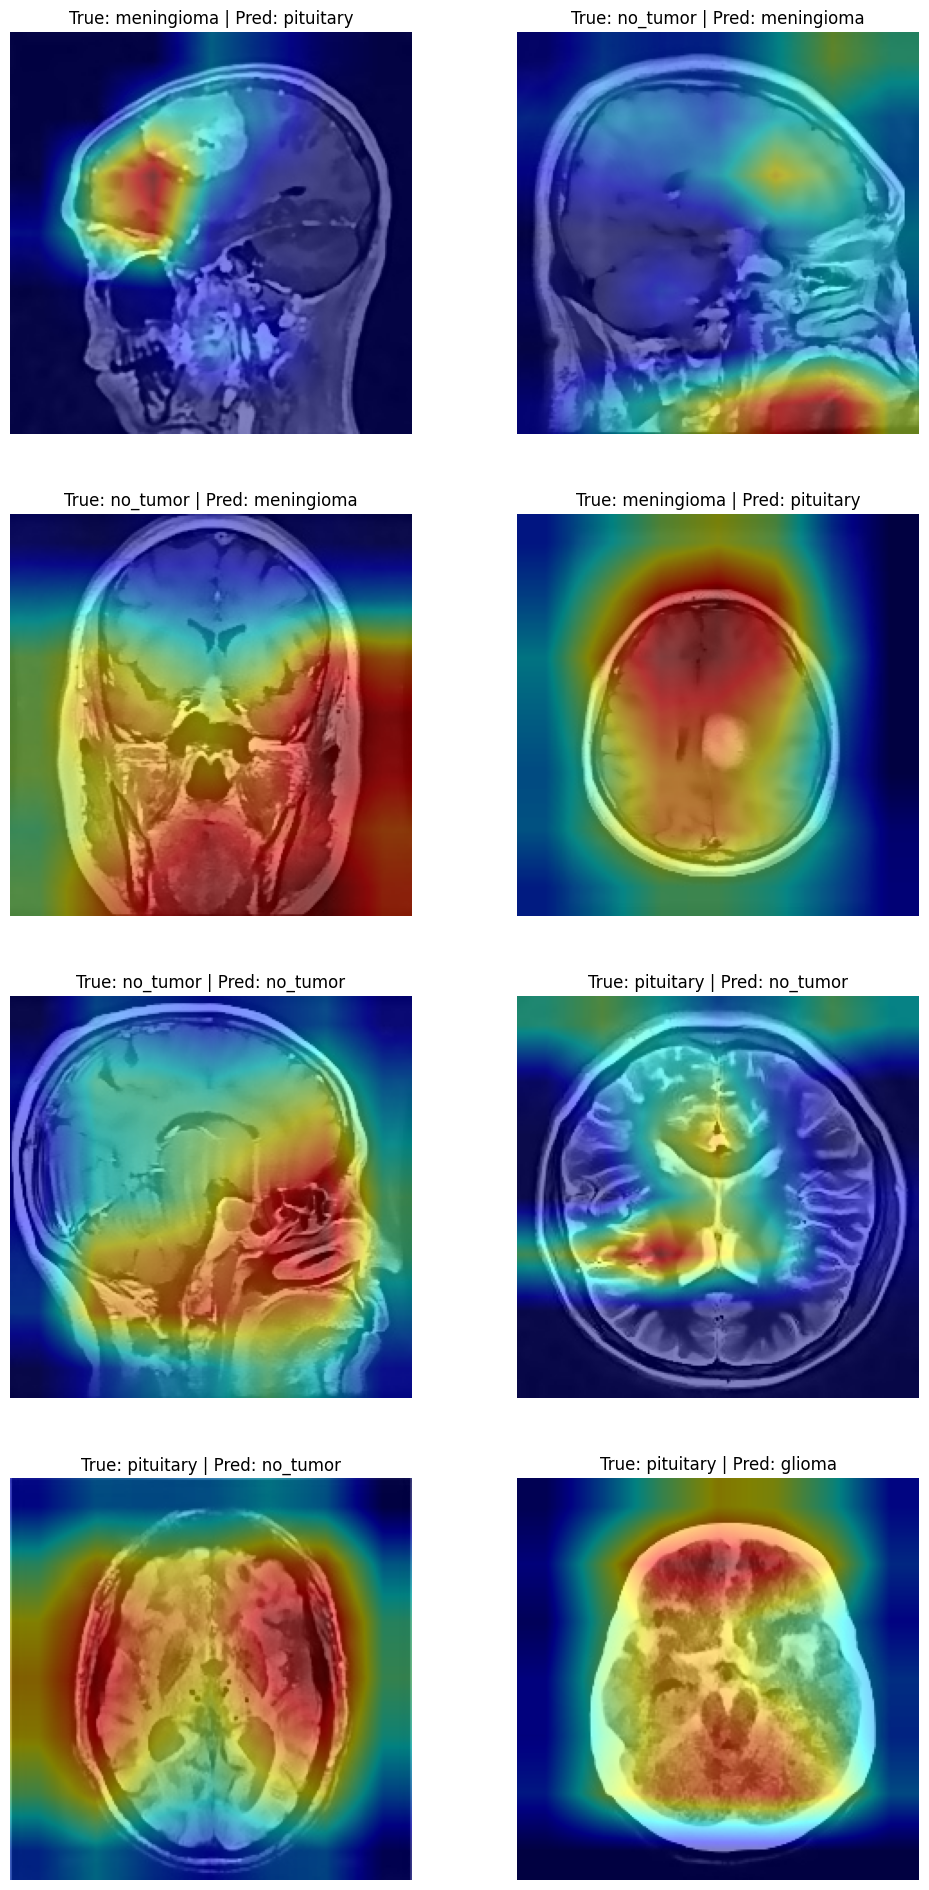

In [18]:
# Cell: visualize saved overlays inline in the notebook
from math import ceil

num = len(results)
cols = 2
rows = ceil(num / cols)
plt.figure(figsize=(12, 6*rows))
for i, r in enumerate(results):
    _, true_label, pred_class, out_orig, out_cam, out_overlay = r
    orig = cv2.cvtColor(cv2.imread(out_orig), cv2.COLOR_BGR2RGB)
    overlay = cv2.cvtColor(cv2.imread(out_overlay), cv2.COLOR_BGR2RGB)
    plt.subplot(rows, cols, i+1)
    plt.imshow(overlay)
    plt.title(f"True: {CLASS_NAMES[true_label]} | Pred: {CLASS_NAMES[pred_class]}")
    plt.axis('off')
plt.show()




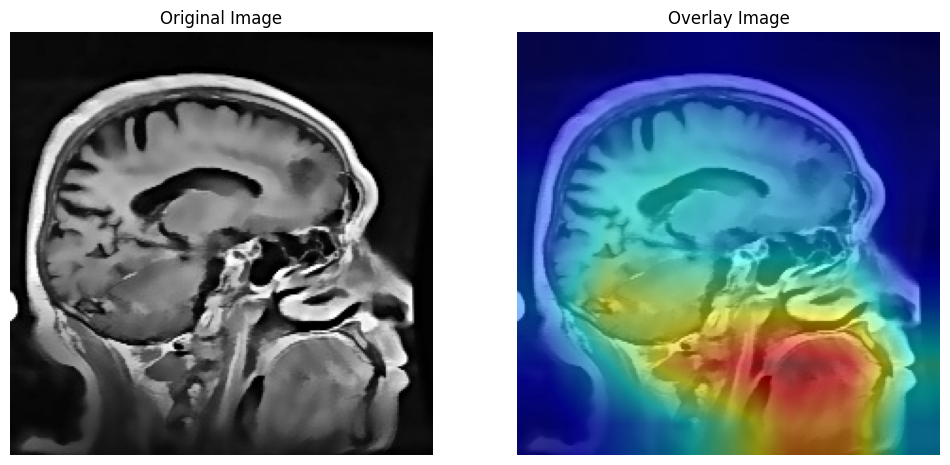

In [23]:
plt.figure(figsize=(12, 6))

# Load the original image from the saved path
orig_image = cv2.cvtColor(cv2.imread(out_orig), cv2.COLOR_BGR2RGB)

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(orig_image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Overlay Image")
plt.imshow(overlay)
plt.axis("off")

plt.show()